# <p style="text-align:center;font-size:36pt;font-family:Corbel;color:#0c777d">Kodluyoruz & Carbon Consulting Data Science Bootcamp Project</p>

<table class="table table-borderless" style="align:center;">

  <tbody>
    <tr>
      <th scope="row"><th scope="col"><p style="text-align:left;"><strong>Project</strong></th>
        <th scope="col"><p style="text-align:right;">Sentiment Classification from Text</p></th>
    </tr>
    <tr>
      <th scope="row"><th scope="col"><p style="text-align:left;"><strong>Dataset</strong></th>
        <th scope="col"><p style="text-align:right;">Tinder Application Reviews on Play Store</th>
    </tr>
    <tr>
      <th scope="row"><th scope="col"><p style="text-align:left;"><strong>Model</strong></th>
        <th scope="col"><p style="text-align:right;">BERT</th>
    </tr>
    <tr>
      <th scope="row"><th scope="col"><p style="text-align:left;"><strong>Owner</strong></th>
        <th scope="col"><p style="text-align:right;">Ayşe Nur Erdem</th>
    </tr>
   </tbody>
</table> 

<p style="text-align:left;font-size:24pt;font-family:Corbel;color:#0c777d">Packages</p>

In [1]:
import numpy as np
import pandas as pd
import datasets as d
import transformers as t
import torch
import json
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CUDA_LAUNCH_BLOCKING=1
print(device)

cuda


<p style="text-align:left;font-size:24pt;font-family:Corbel;color:#0c777d">Overview</p>

In [3]:
dataset = pd.read_csv("../input/tinder-google-play-store-review/tinder_google_play_reviews.csv")
dataset.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOElIsyH7v-Hhhzu6PuI9DIsN7VUcxx0h5SBKpK...,Nikhilesh Verma,https://play-lh.googleusercontent.com/a-/AOh14...,Fake app,1,0,NaN,2022-04-09 11:15:07,NaN,NaN
1,gp:AOqpTOH0smXMRH_GMXoPk0F6hUbPoaQ6e6a29shjEfS...,Tristan Jones,https://play-lh.googleusercontent.com/a/AATXAJ...,"I'm not a racist person, l respect all races b...",2,0,13.5.0,2022-04-09 11:03:58,NaN,NaN
2,gp:AOqpTOFKzNUWcq_qhxzt2Pv8FsukbMOar4kE8f9m2yD...,Lola Racheal,https://play-lh.googleusercontent.com/a/AATXAJ...,I was banned from using the app i don't know w...,1,0,13.5.0,2022-04-09 11:00:09,NaN,NaN


In [4]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
score,532711.0,3.003629,1.758503,0.0,1.0,3.0,5.0,5.0
thumbsUpCount,532711.0,1.731988,26.501551,0.0,0.0,0.0,0.0,5506.0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532711 entries, 0 to 532710
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              532711 non-null  object
 1   userName              532706 non-null  object
 2   userImage             532711 non-null  object
 3   content               531367 non-null  object
 4   score                 532711 non-null  int64 
 5   thumbsUpCount         532711 non-null  int64 
 6   reviewCreatedVersion  425017 non-null  object
 7   at                    532711 non-null  object
 8   replyContent          47665 non-null   object
 9   repliedAt             47665 non-null   object
dtypes: int64(2), object(8)
memory usage: 40.6+ MB


In [6]:
print(f"THERE ARE \033[31m{dataset['content'].isnull().sum()}\033[0m NULL REVIEWS IN DATASET.")

THERE ARE 1344 NULL REVIEWS IN DATASET.


In [7]:
dataset["score"].value_counts()

1    199251
5    186638
4     65460
3     43063
2     38298
0         1
Name: score, dtype: int64

<div class="alert alert-info" role="alert">
  There is 1 entry rated 0, let's look at this review closer and decide whether drop it or not.
</div>

In [8]:
print(dataset[dataset["score"] == 0]["content"].item())

Love it but ...my match is not replying its a prblm on app or smthing else 
please tell me


In [9]:
idx = dataset[dataset["score"] == 0].index.item()
dataset["score"][idx] = 3

In [10]:
for i in range(5):
    print(f"\33[34mREVIEW {i+1}:\033[0m",dataset.sort_values("thumbsUpCount", ascending=False)["content"].to_list()[i],"\n\33[34mTHUMBS UP COUNT: \033[0m", dataset.sort_values("thumbsUpCount", ascending=False)["thumbsUpCount"].to_list()[i],"\n\n")

REVIEW 1: I got banned from Tinder for absolutely no reason, I know that I did nothing wrong, sent no inappropriate messages, my profile photos are decent, did not abuse anyone, have NOT broken ANY community guidelines at all, and yet they banned me. Got an email back after I asked why they banned me, didn't get an answer except "you broke community guidelines" which I haven't. I've read blogs and apparently this happens all the time. I was a paying customer, had Gold for three months. I need a refund. 
THUMBS UP COUNT:  5506 


REVIEW 2: Not bad! One thing that would be great is the ability to send brief messages with super likes! Lots of people either use it by accident or feel weird about receiving them since there's no context- But I think a girl would be more welcome to a super like if she knew why she received one. You might say to her "Wow, I really love the way you style your hair!" or something like that. 
THUMBS UP COUNT:  4041 


REVIEW 3: Ugh, I used this app off and on for

<div class="alert alert-danger" role="alert">
  The reviews having the most thumbs ups are about getting banned from application for no reason.
</div>

In [11]:
for _ in range(5):
    idx = np.random.randint(low=0, high=len(dataset), size=1).item()
    print(f"\33[34mREVIEW {idx+1}:\033[0m",dataset.sort_values("thumbsUpCount", ascending=False)["content"].to_list()[idx],"\n\33[34mTHUMBS UP COUNT: \033[0m", dataset.sort_values("thumbsUpCount", ascending=False)["thumbsUpCount"].to_list()[idx],"\n\n")

REVIEW 328970: 👍👍 
THUMBS UP COUNT:  0 


REVIEW 114044: New update  is great much better UI 
THUMBS UP COUNT:  0 


REVIEW 35229: If you really want to find something, be careful and super persistent. 
THUMBS UP COUNT:  1 


REVIEW 468300: Good enough app. Compared with others. Not free at all. 
THUMBS UP COUNT:  0 


REVIEW 89535: So fun for hot babes 
THUMBS UP COUNT:  0 




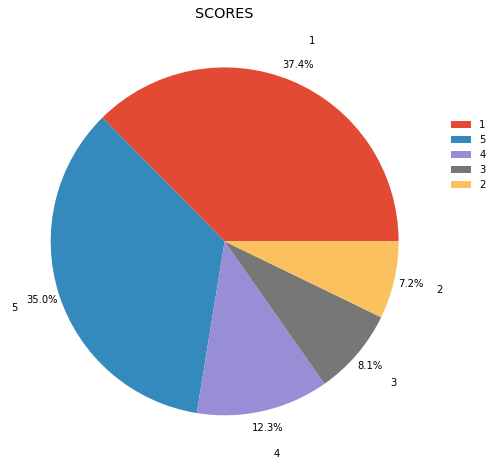

In [12]:
plt.figure(figsize=(12,8))
plt.pie(dataset["score"].value_counts(), labels=dataset["score"].value_counts().index, autopct='%1.1f%%', startangle=0, pctdistance=1.1,labeldistance=1.25)
plt.title("SCORES")
plt.legend(frameon=False, bbox_to_anchor=(1,0.8))
plt.show()

<p style="text-align:left;font-size:24pt;font-family:Corbel;color:#0c777d">Preprocessing Text</p>

<span style="font-family:Corbel;font-size:14pt;">
   To feed the language model with text input, we need to prepare the input as the model to be able to interpret. There are some ways to preprocess this type of input in proper format such as converting words into numbers or vectors.<br><br>
    <span style="color:#0c777d">Tokenizing</span><br>Tokenizing is a process to split sequnce of words/sentences into units/words.<br><br>
    <span style="color:#0c777d">Encoding</span><br>
    Converting a string to a sequence of ids (integer), using the tokenizer and vocabulary.<br><br>

In [13]:
MODEL_NAME = "bert-base-uncased"
tokenizer = t.AutoTokenizer.from_pretrained(MODEL_NAME, padding=True, truncation=True, max_length=140, return_tensors="pt")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [14]:
example = dataset["content"][np.random.randint(low=0, high=len(dataset), size=1).item()]
print(f"\33[34mREVIEW: \33[0m'{example}'\n")
print(f"\33[34mTOKENIZED VECTOR: \33[0m{tokenizer.tokenize(example)}\n")
print(f"\33[34mTOKEN IDS: \33[0m{tokenizer.convert_tokens_to_ids(tokenizer.tokenize(example))}\n")
print(f"\33[34mENCODED VECTOR: \33[0m{tokenizer.encode(example)}\n")
print(f"\33[34mENCODED(+) VECTOR: \33[0m{tokenizer.encode_plus(example, return_tensors='pt')}")

REVIEW: 'Its a great app me and my wife love it'

TOKENIZED VECTOR: ['its', 'a', 'great', 'app', 'me', 'and', 'my', 'wife', 'love', 'it']

TOKEN IDS: [2049, 1037, 2307, 10439, 2033, 1998, 2026, 2564, 2293, 2009]

ENCODED VECTOR: [101, 2049, 1037, 2307, 10439, 2033, 1998, 2026, 2564, 2293, 2009, 102]

ENCODED(+) VECTOR: {'input_ids': tensor([[  101,  2049,  1037,  2307, 10439,  2033,  1998,  2026,  2564,  2293,
          2009,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


<span style="font-size:16pt;font-family:Corbel;color:#0c777d;">'attention_mask':</span><span style="font-size:12pt;font-family:Corbel;">This argument indicates to the model which tokens should be attended to, and which should not.</span>

<p style="text-align:left;font-size:24pt;font-family:Corbel;color:#0c777d">Preparering Dataset</p>

In [15]:
dataset = dataset[["content","score"]]
dataset.rename(columns={"score": "labels"}, inplace=True)
dataset.dropna(how="any", axis=0, inplace=True)
dataset["labels"] = [0 if i < 3 else 1 for i in dataset["labels"]]
dataset.head(3)

,content,labels
0,Fake app,0
1,"I'm not a racist person, l respect all races b...",0
2,I was banned from using the app i don't know w...,0


In [16]:
hf_dataset = d.Dataset.from_pandas(dataset)
hf_dataset

Dataset({
    features: ['content', 'labels', '__index_level_0__'],
    num_rows: 531367
})

In [17]:
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = t.AutoTokenizer.from_pretrained(MODEL_NAME, padding=True, truncation=True, return_tensors="pt")

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [18]:
def tokenize_function(example):
    return tokenizer(example["content"], truncation=True)


tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
data_collator = t.DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/532 [00:00<?, ?ba/s]

In [19]:
tokenized_dataset

Dataset({
    features: ['content', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 531367
})

In [20]:
BATCH_SIZE = 8
NUM_LABELS = 2

In [21]:
tokenized_dataset = tokenized_dataset.remove_columns(["__index_level_0__","content"])
tokenized_dataset.set_format("torch")
tokenized_dataset = tokenized_dataset.train_test_split(0.2)

In [22]:
train_dataloader = torch.utils.data.DataLoader(tokenized_dataset["train"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
test_dataloader = torch.utils.data.DataLoader(tokenized_dataset["test"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

<p style="text-align:left;font-size:24pt;font-family:Corbel;color:#0c777d">Model</p>

In [23]:
model_from_checkpoint = t.AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [24]:
optimizer = t.AdamW(model_from_checkpoint.parameters(), lr=5e-5)

In [25]:
EPOCHS = 3
NUM_STEPS = EPOCHS * len(train_dataloader)
lr_scheduler = t.get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=NUM_STEPS,
)
print(NUM_STEPS)

159411


In [26]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 112]),
 'attention_mask': torch.Size([8, 112])}

<p style="text-align:left;font-size:24pt;font-family:Corbel;color:#0c777d">Training</p>

In [27]:
metric = d.load_metric("accuracy")
progress_bar = tqdm(range(NUM_STEPS))
train_logits = []
train_predictions = []
train_accuracy = 0

for epoch in range(EPOCHS):
    for batch in train_dataloader:
        model_from_checkpoint.train()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_from_checkpoint(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
        model_from_checkpoint.eval()
        
        with torch.no_grad():
            outputs = model_from_checkpoint(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        train_logits.extend(logits)
        train_predictions.extend(predictions)

        metric.add_batch(predictions=predictions, references=batch["labels"])


    train_accuracy += metric.compute()["accuracy"] / EPOCHS
    print(f"\33[34mEPOCH {epoch} ENDED\33[0m")
    
print("\33[34mTRAIN ACCURACY: \033[0m", train_accuracy)

Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

  0%|          | 0/159411 [00:00<?, ?it/s]

EPOCH 0 ENDED
EPOCH 1 ENDED
EPOCH 2 ENDED
TRAIN ACCURACY:  0.9115017184474927


<p style="text-align:left;font-size:24pt;font-family:Corbel;color:#0c777d">Testing</p>

In [28]:
test_logits = []
test_predictions = []
model_from_checkpoint.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_from_checkpoint(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    test_logits.extend(logits)
    test_predictions.extend(predictions)
    test_metrics = metric.add_batch(predictions=predictions, references=batch["labels"])
    
test_accuracy = metric.compute()["accuracy"]

print("\33[34mTEST ACCURACY: \033[0m", test_accuracy)

TEST ACCURACY:  0.8979336432241188


<p style="text-align:left;font-size:24pt;font-family:Corbel;color:#0c777d">Evaluation Model Performance</p>

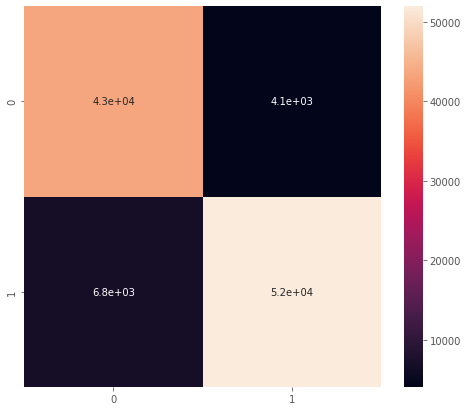

In [29]:
predictions = [i.item() for i in test_predictions]
actual_labels = test_dataloader.dataset["labels"]
plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(actual_labels, predictions), annot=True)
plt.show()

In [30]:
print(classification_report(actual_labels, predictions))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     47524
           1       0.93      0.88      0.91     58750

    accuracy                           0.90    106274
   macro avg       0.90      0.90      0.90    106274
weighted avg       0.90      0.90      0.90    106274



In [62]:
print("\33[44m    TRAIN PREDICTIONS    \033[0m")
for i in range(10):
    print(f"\n\33[34mREVIEW {i+1}: \033[0m",dataset["content"][i])
    print(f"\33[34mPREDICTION: \033[0m", train_predictions[i].item())
    print(f"\33[34mACTUAL: \033[0m", dataset["labels"][i].item())
print()
print("\33[44m    TEST PREDICTIONS    \033[0m")
for i in range(1,11):
    print(f"\n\33[34mREVIEW {i}: \033[0m",dataset["content"].iloc[-i])
    print(f"\33[34mPREDICTION: \033[0m", test_predictions[-i].item())
    print(f"\33[34mACTUAL: \033[0m", actual_labels[-i].item())    

    TRAIN PREDICTIONS    

REVIEW 1:  Fake app
PREDICTION:  1
ACTUAL:  0

REVIEW 2:  I'm not a racist person, l respect all races but l keep getting different races from my own, then l get run out of potential matches after putting it on full length, the app is not bad just please add a race option, Thank you.
PREDICTION:  0
ACTUAL:  0

REVIEW 3:  I was banned from using the app i don't know why and i have been trying to resolve this please i need to know why
PREDICTION:  0
ACTUAL:  0

REVIEW 4:  Ive been matching with people but they never show up in my match list so i cant talk to anyone
PREDICTION:  1
ACTUAL:  0

REVIEW 5:  Got banned, don't know why or how? There isn't even a way to get support or help.
PREDICTION:  1
ACTUAL:  0

REVIEW 6:  I lost my money. After purchase gold membership from Google redem my account got banned I lost money 😑
PREDICTION:  0
ACTUAL:  0

REVIEW 7:  Worst aap it's all about user come and get their premiums
PREDICTION:  0
ACTUAL:  0

REVIEW 8:  lmao thi

<p style="text-align:left;font-size:24pt;font-family:Corbel;color:#0c777d">Saving Model Outputs</p>

In [37]:
torch.save(model_from_checkpoint.state_dict(), "model.pth")

In [ ]:
predictions_train = [i.item() for i in train_predictions]

with open("test_predictions.json","w") as f:
    json.dump(predictions, f)
with open("train_predictions.json","w") as f:
    json.dump(predictions_train, f)

In [48]:
logits_train = [i.tolist() for i in train_logits]
logits_test = [i.tolist() for i in test_logits]
with open("test_logits.json","w") as f:
    json.dump(logits_test, f)
with open("train_logits.json","w") as f:
    json.dump(logits_train, f)